In [29]:
# import relevant libraries
from src.common import *

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats

import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings('ignore')

In [4]:
# load Consumer Price Index for Israel

cpi = pd.read_csv('ISRCPIALLQINMEI.csv', names=['date','amount'], header=0)
print(cpi.dtypes)
print(cpi.head())

# change dates to datetime index
cpi['date'] = pd.to_datetime(cpi['date'], format='%Y-%m-%d')
cpi.set_index('date', inplace=True)
print("------------------ CPI for Israel ----------------------")
print(cpi)
print("---------------------------------------------------------")

date       object
amount    float64
dtype: object
         date     amount
0  2001-01-01  75.436828
1  2001-04-01  76.478495
2  2001-07-01  77.318548
3  2001-10-01  77.217742
4  2002-01-01  78.393817
------------------ CPI for Israel ----------------------
                amount
date                  
2001-01-01   75.436828
2001-04-01   76.478495
2001-07-01   77.318548
2001-10-01   77.217742
2002-01-01   78.393817
...                ...
2021-10-01  103.259409
2022-01-01  104.301075
2022-04-01  106.283602
2022-07-01  107.829301
2022-10-01  108.635753

[88 rows x 1 columns]
---------------------------------------------------------


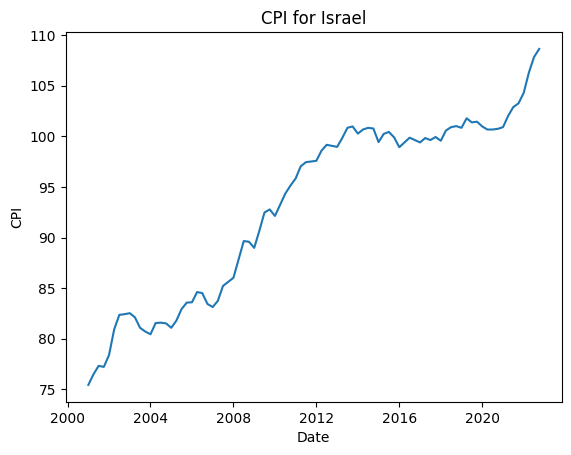

In [5]:
# plotting the series
plt.plot(cpi.amount)
plt.title('CPI for Israel')
plt.ylabel('CPI')
plt.xlabel('Date')
plt.show()

In [32]:
# Preparing the data to check different transformations
y = cpi.amount
dy = y.diff().dropna()
ly = np.log(y)
dly = np.log(y).diff().dropna()
ddly = np.log(y).diff().dropna().diff().dropna()

print(dly)

date
2001-04-01    0.013714
2001-07-01    0.010924
2001-10-01   -0.001305
2002-01-01    0.015116
2002-04-01    0.031642
                ...   
2021-10-01    0.003586
2022-01-01    0.010037
2022-04-01    0.018829
2022-07-01    0.014438
2022-10-01    0.007451
Name: amount, Length: 87, dtype: float64


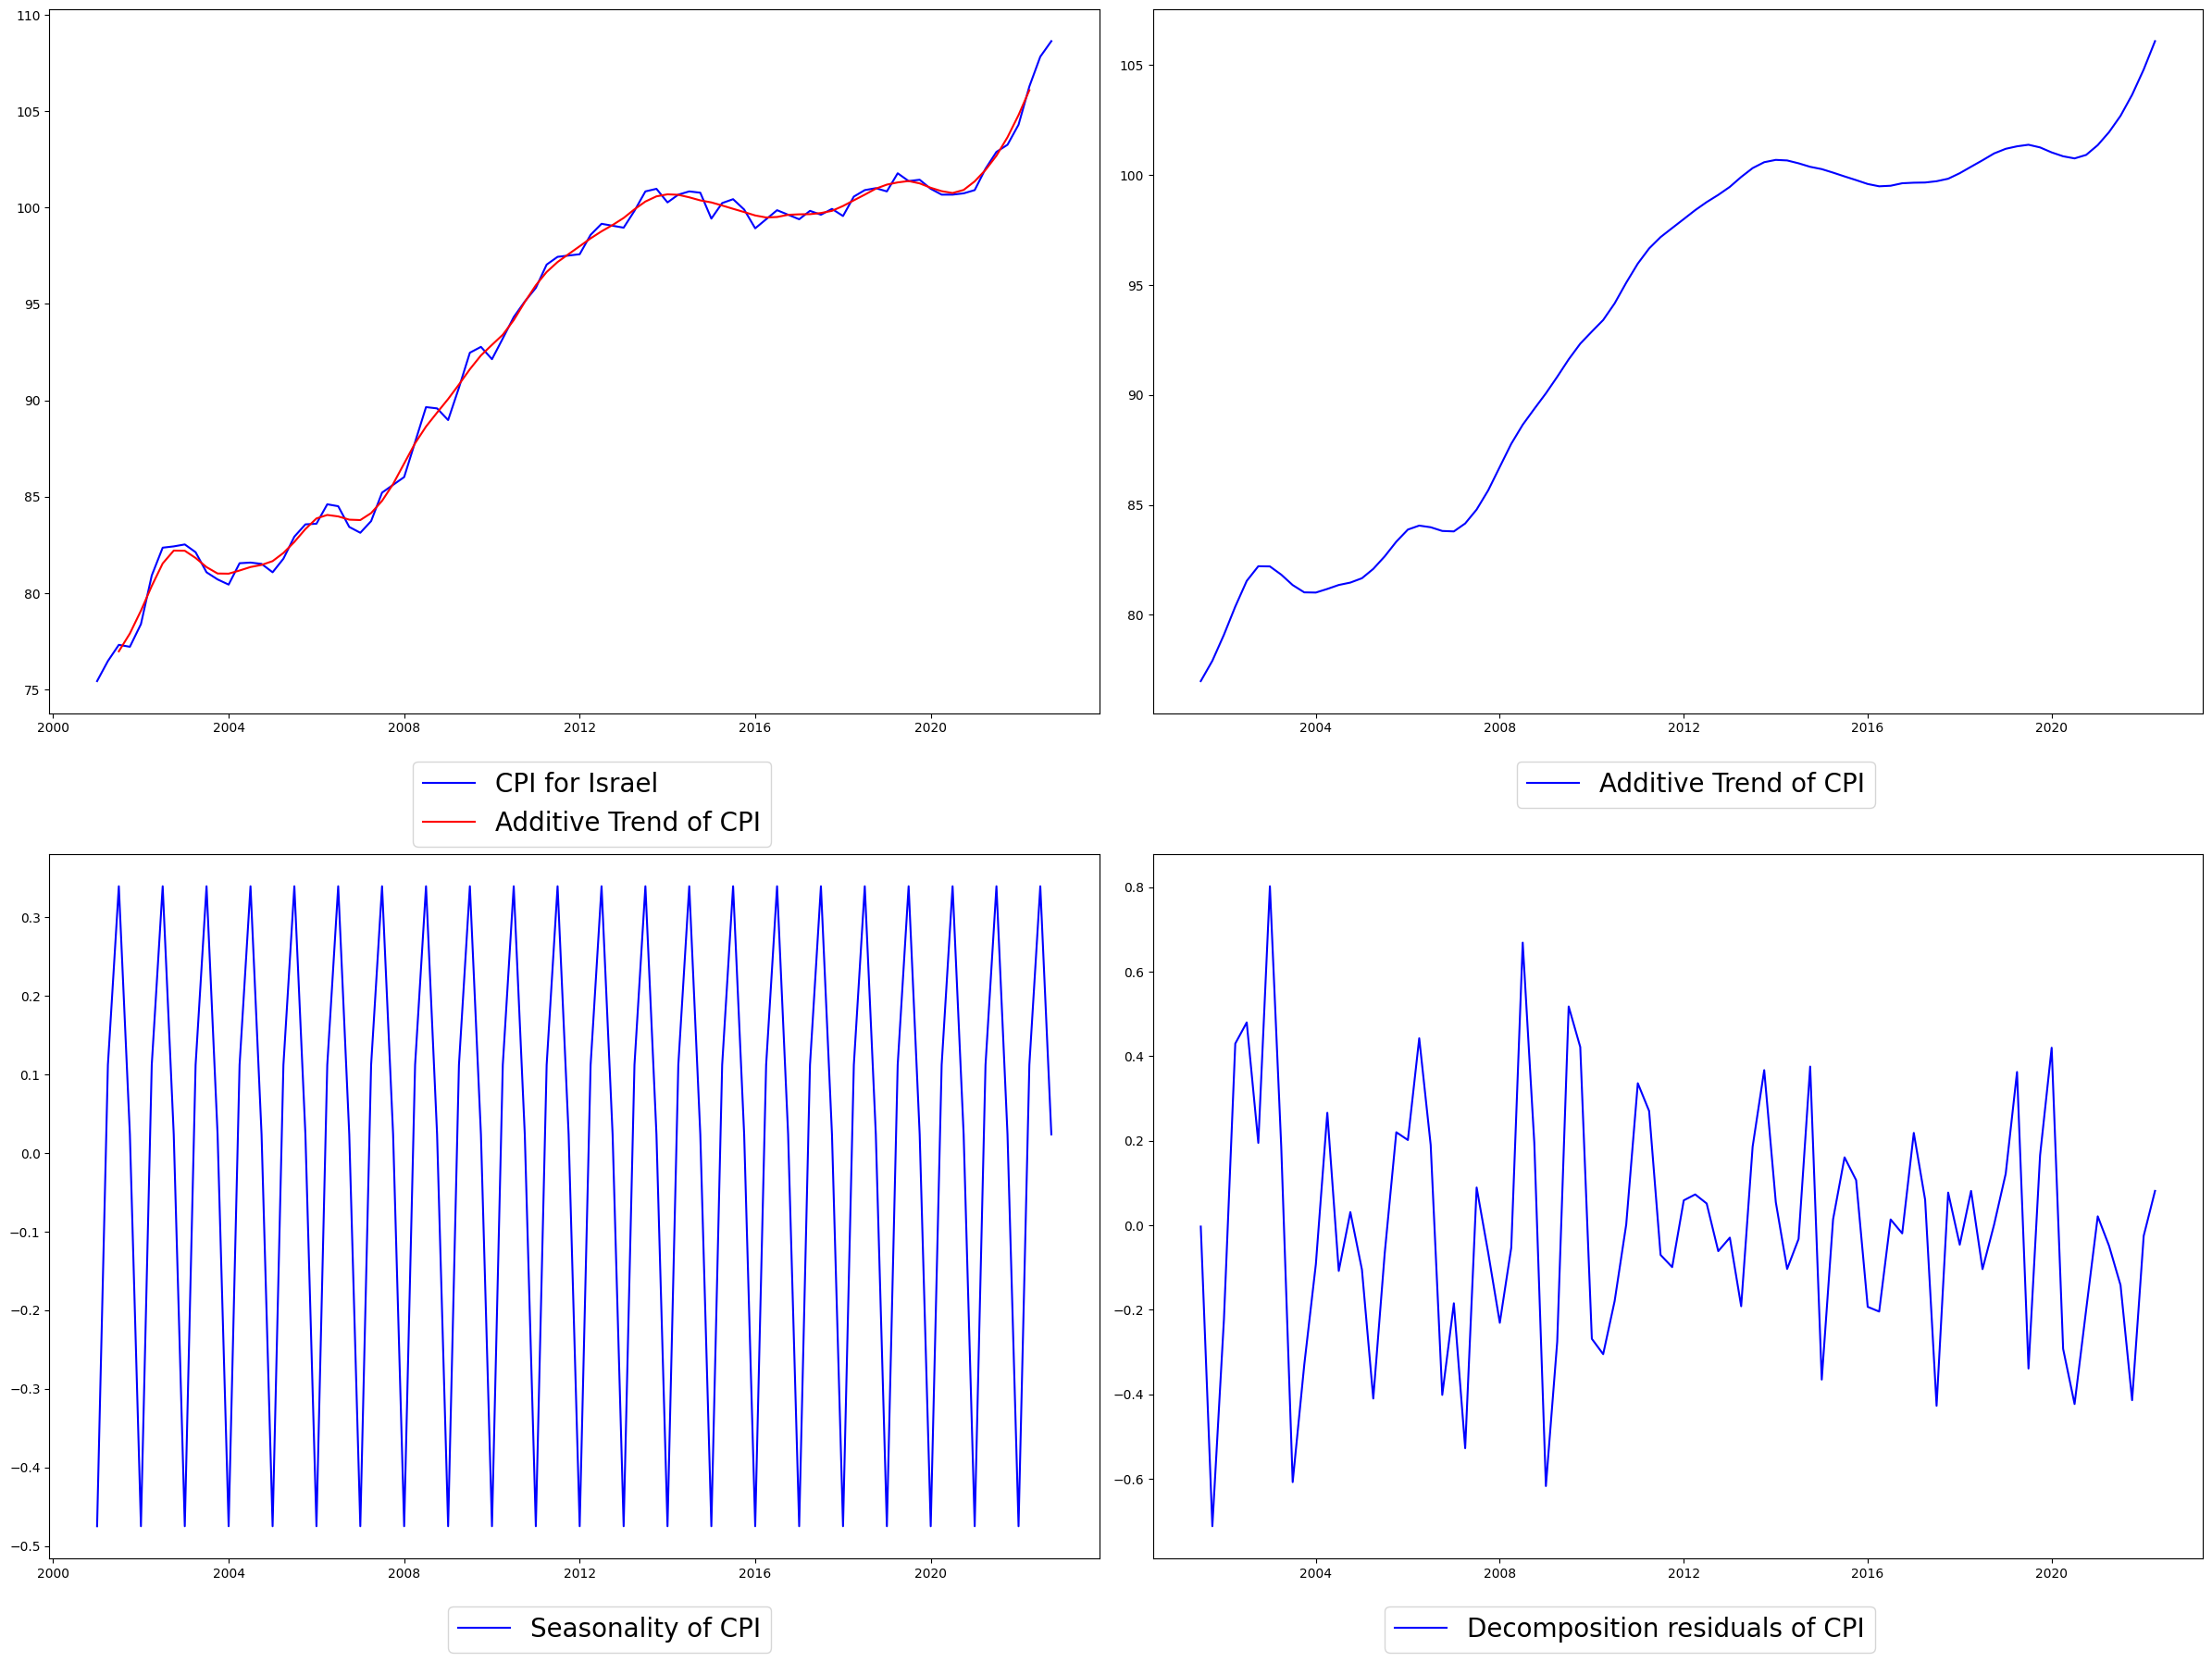

In [7]:
# decompose the series - additive model
additive = seasonal_decompose(y, model='additive')
trend_estimate = additive.trend
periodic_estimate = additive.seasonal
residual = additive.resid

plt.rcParams["figure.figsize"] = (24,18)
plt.subplot(221)
plt.plot(cpi.amount ,label='CPI for Israel', color='blue')
plt.plot(trend_estimate ,label='Additive Trend of CPI' , color='red')
plt.legend(loc='best',fontsize=20 , bbox_to_anchor=(0.70, -0.05))
plt.subplot(222)
plt.plot(trend_estimate,label='Additive Trend of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(223)
plt.plot(periodic_estimate,label='Seasonality of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(224)
plt.plot(residual,label='Decomposition residuals of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.tight_layout()
plt.show()

A visual examination of the time series, ...

In [10]:
# decompose with seasonal decompose - additive
additive = seasonal_decompose(y, model='additive')
additive_components = pd.DataFrame([additive.observed, additive.trend,
                                    additive.seasonal, additive.resid]).T
additive_components.columns = ["observed", "trend", "seasonal", "resid"]
additive_components['sum'] = additive_components.sum(numeric_only=True, axis=1)
additive_components['product'] = additive_components.loc[:,"trend":"resid"].product(axis=1, numeric_only=True)

In [16]:
# check stationarity for residuals
y_add_resid = additive_components.resid.dropna()
print("\n-------------------------------------------------")
print("Augmented Dickey-Fuller (ADF) test")
print("    H0: unit root (variable is NOT stationary)")
print("    H0: no unit root (variable is stationary)")
print("---------------------------------------------------")

print("ADF test for residuals - various underlying models:")
res = tsa.adfuller(y_add_resid, regression='c',autolag='AIC')
print("    (1) ADF p-value (const):",res[1])
res = tsa.adfuller(y_add_resid, regression='ct',autolag='AIC')
print("    (2) ADF p-value (const + trend):",res[1])
res = tsa.adfuller(y_add_resid, regression='ctt',autolag='AIC')
print("    (3) ADF p-value (const + trend + quad trend):",res[1])
res = tsa.adfuller(y_add_resid, regression='n',autolag='AIC')
print("    (4) ADF p-value (no const + no trend):",res[1])


-------------------------------------------------
Augmented Dickey-Fuller (ADF) test
    H0: unit root (variable is NOT stationary)
    H0: no unit root (variable is stationary)
---------------------------------------------------
ADF test for residuals - various underlying models:
    (1) ADF p-value (const): 4.209624283724807e-15
    (2) ADF p-value (const + trend): 1.3848848309946499e-13
    (3) ADF p-value (const + trend + quad trend): 7.235945666946525e-13
    (4) ADF p-value (no const + no trend): 8.369164143989653e-16


Using the formal tests, we learn that...

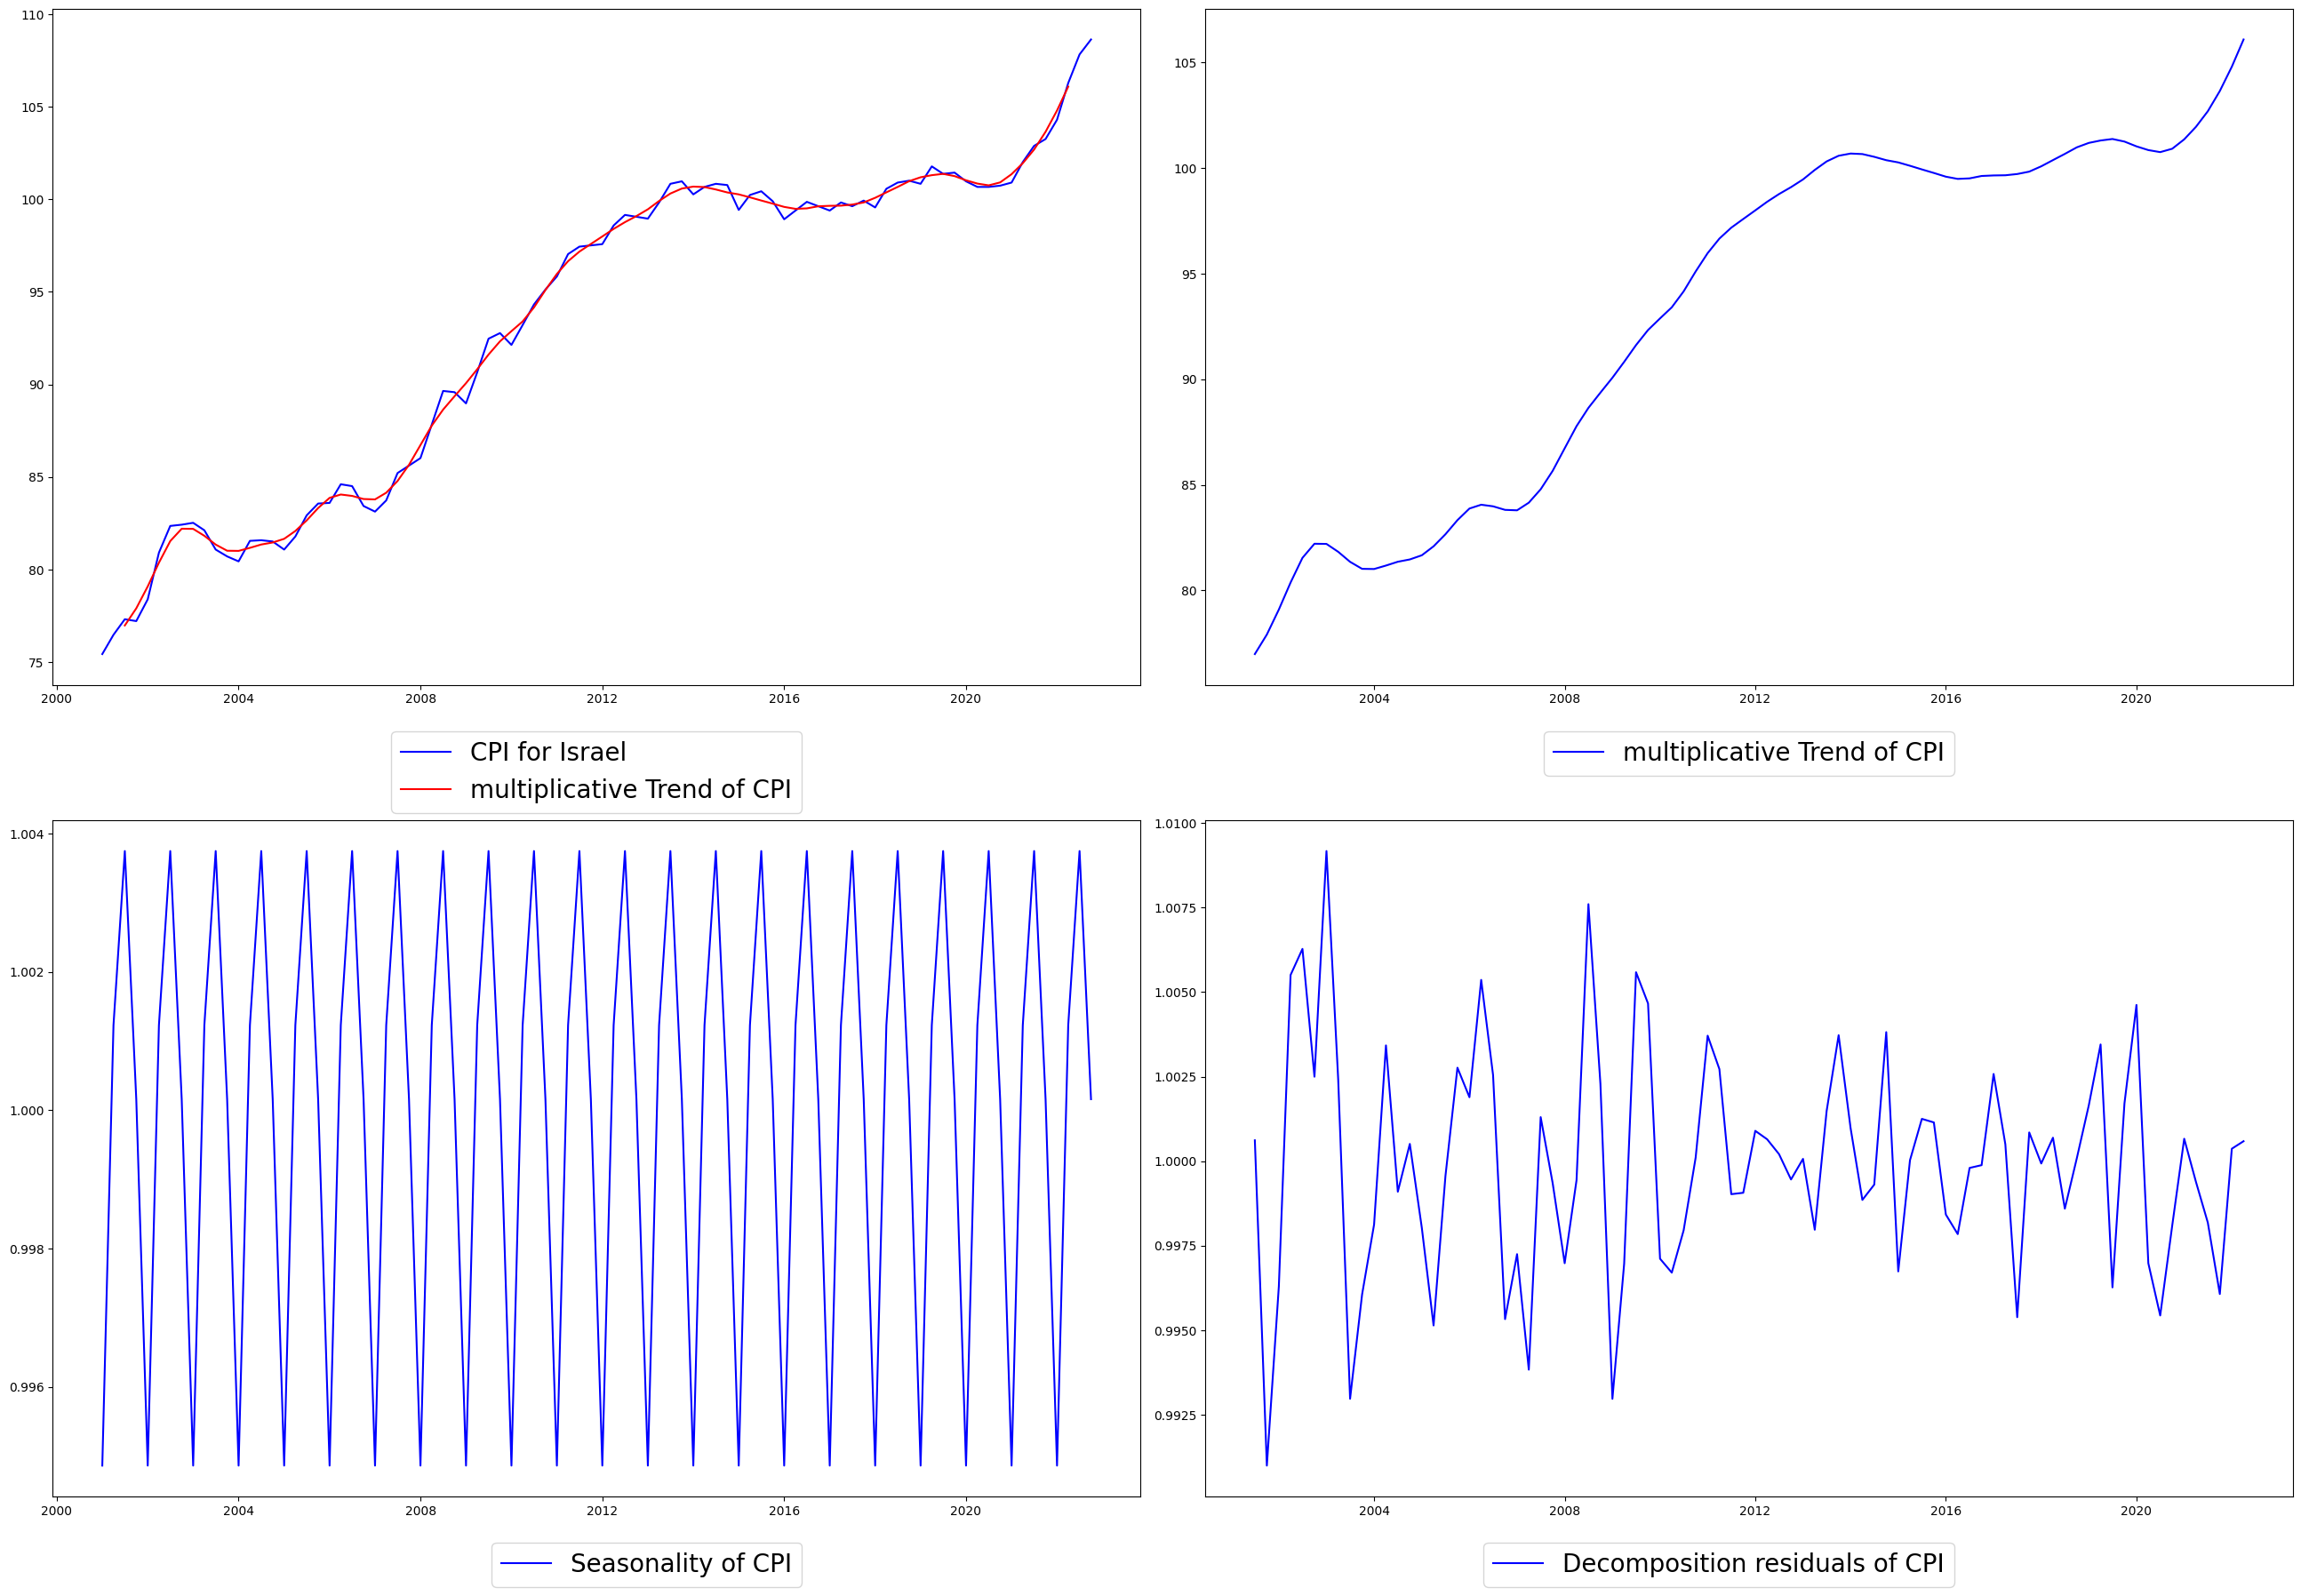

In [12]:
multiplicative = seasonal_decompose(y, model='multiplicative')
trend_estimate = multiplicative.trend
periodic_estimate = multiplicative.seasonal
residual = multiplicative.resid

plt.rcParams["figure.figsize"] = (26,18)
plt.subplot(221)
plt.plot(cpi.amount ,label='CPI for Israel', color='blue')
plt.plot(trend_estimate ,label='multiplicative Trend of CPI' , color='red')
plt.legend(loc='best',fontsize=20 , bbox_to_anchor=(0.70, -0.05))
plt.subplot(222)
plt.plot(trend_estimate,label='multiplicative Trend of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(223)
plt.plot(periodic_estimate,label='Seasonality of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(224)
plt.plot(residual,label='Decomposition residuals of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.tight_layout()
plt.show()

A visual examination of the multiplicative decomposition of the series...

In [15]:
# decompose with seasonal decompose - multiplicative
multiplicative = seasonal_decompose(y, model='multiplicative')
multiplicative_components = pd.DataFrame([multiplicative.observed, multiplicative.trend,
                                    multiplicative.seasonal, multiplicative.resid]).T
multiplicative_components.columns = ["observed", "trend", "seasonal", "resid"]
multiplicative_components['sum'] = multiplicative_components.sum(numeric_only=True, axis=1)
multiplicative_components['product'] = multiplicative_components.loc[:,"trend":"resid"].product(axis=1, numeric_only=True)

In [17]:
# check stationarity for residuals
y_mult_resid = multiplicative_components.resid.dropna()
print("\n-------------------------------------------------")
print("Augmented Dickey-Fuller (ADF) test")
print("    H0: unit root (variable is NOT stationary)")
print("    H0: no unit root (variable is stationary)")
print("---------------------------------------------------")

print("ADF test for residuals - various underlying models:")
res = tsa.adfuller(y_mult_resid, regression='c',autolag='AIC')
print("    (1) ADF p-value (const):",res[1])
res = tsa.adfuller(y_mult_resid, regression='ct',autolag='AIC')
print("    (2) ADF p-value (const + trend):",res[1])
res = tsa.adfuller(y_mult_resid, regression='ctt',autolag='AIC')
print("    (3) ADF p-value (const + trend + quad trend):",res[1])
res = tsa.adfuller(y_mult_resid, regression='n',autolag='AIC')
print("    (4) ADF p-value (no const + no trend):",res[1])


-------------------------------------------------
Augmented Dickey-Fuller (ADF) test
    H0: unit root (variable is NOT stationary)
    H0: no unit root (variable is stationary)
---------------------------------------------------
ADF test for residuals - various underlying models:
    (1) ADF p-value (const): 1.8533231537674996e-15
    (2) ADF p-value (const + trend): 7.85848705026051e-14
    (3) ADF p-value (const + trend + quad trend): 4.0467793518065995e-13
    (4) ADF p-value (no const + no trend): 0.5063985431731224


Formal tests of the multiplicative decomposition reveal...

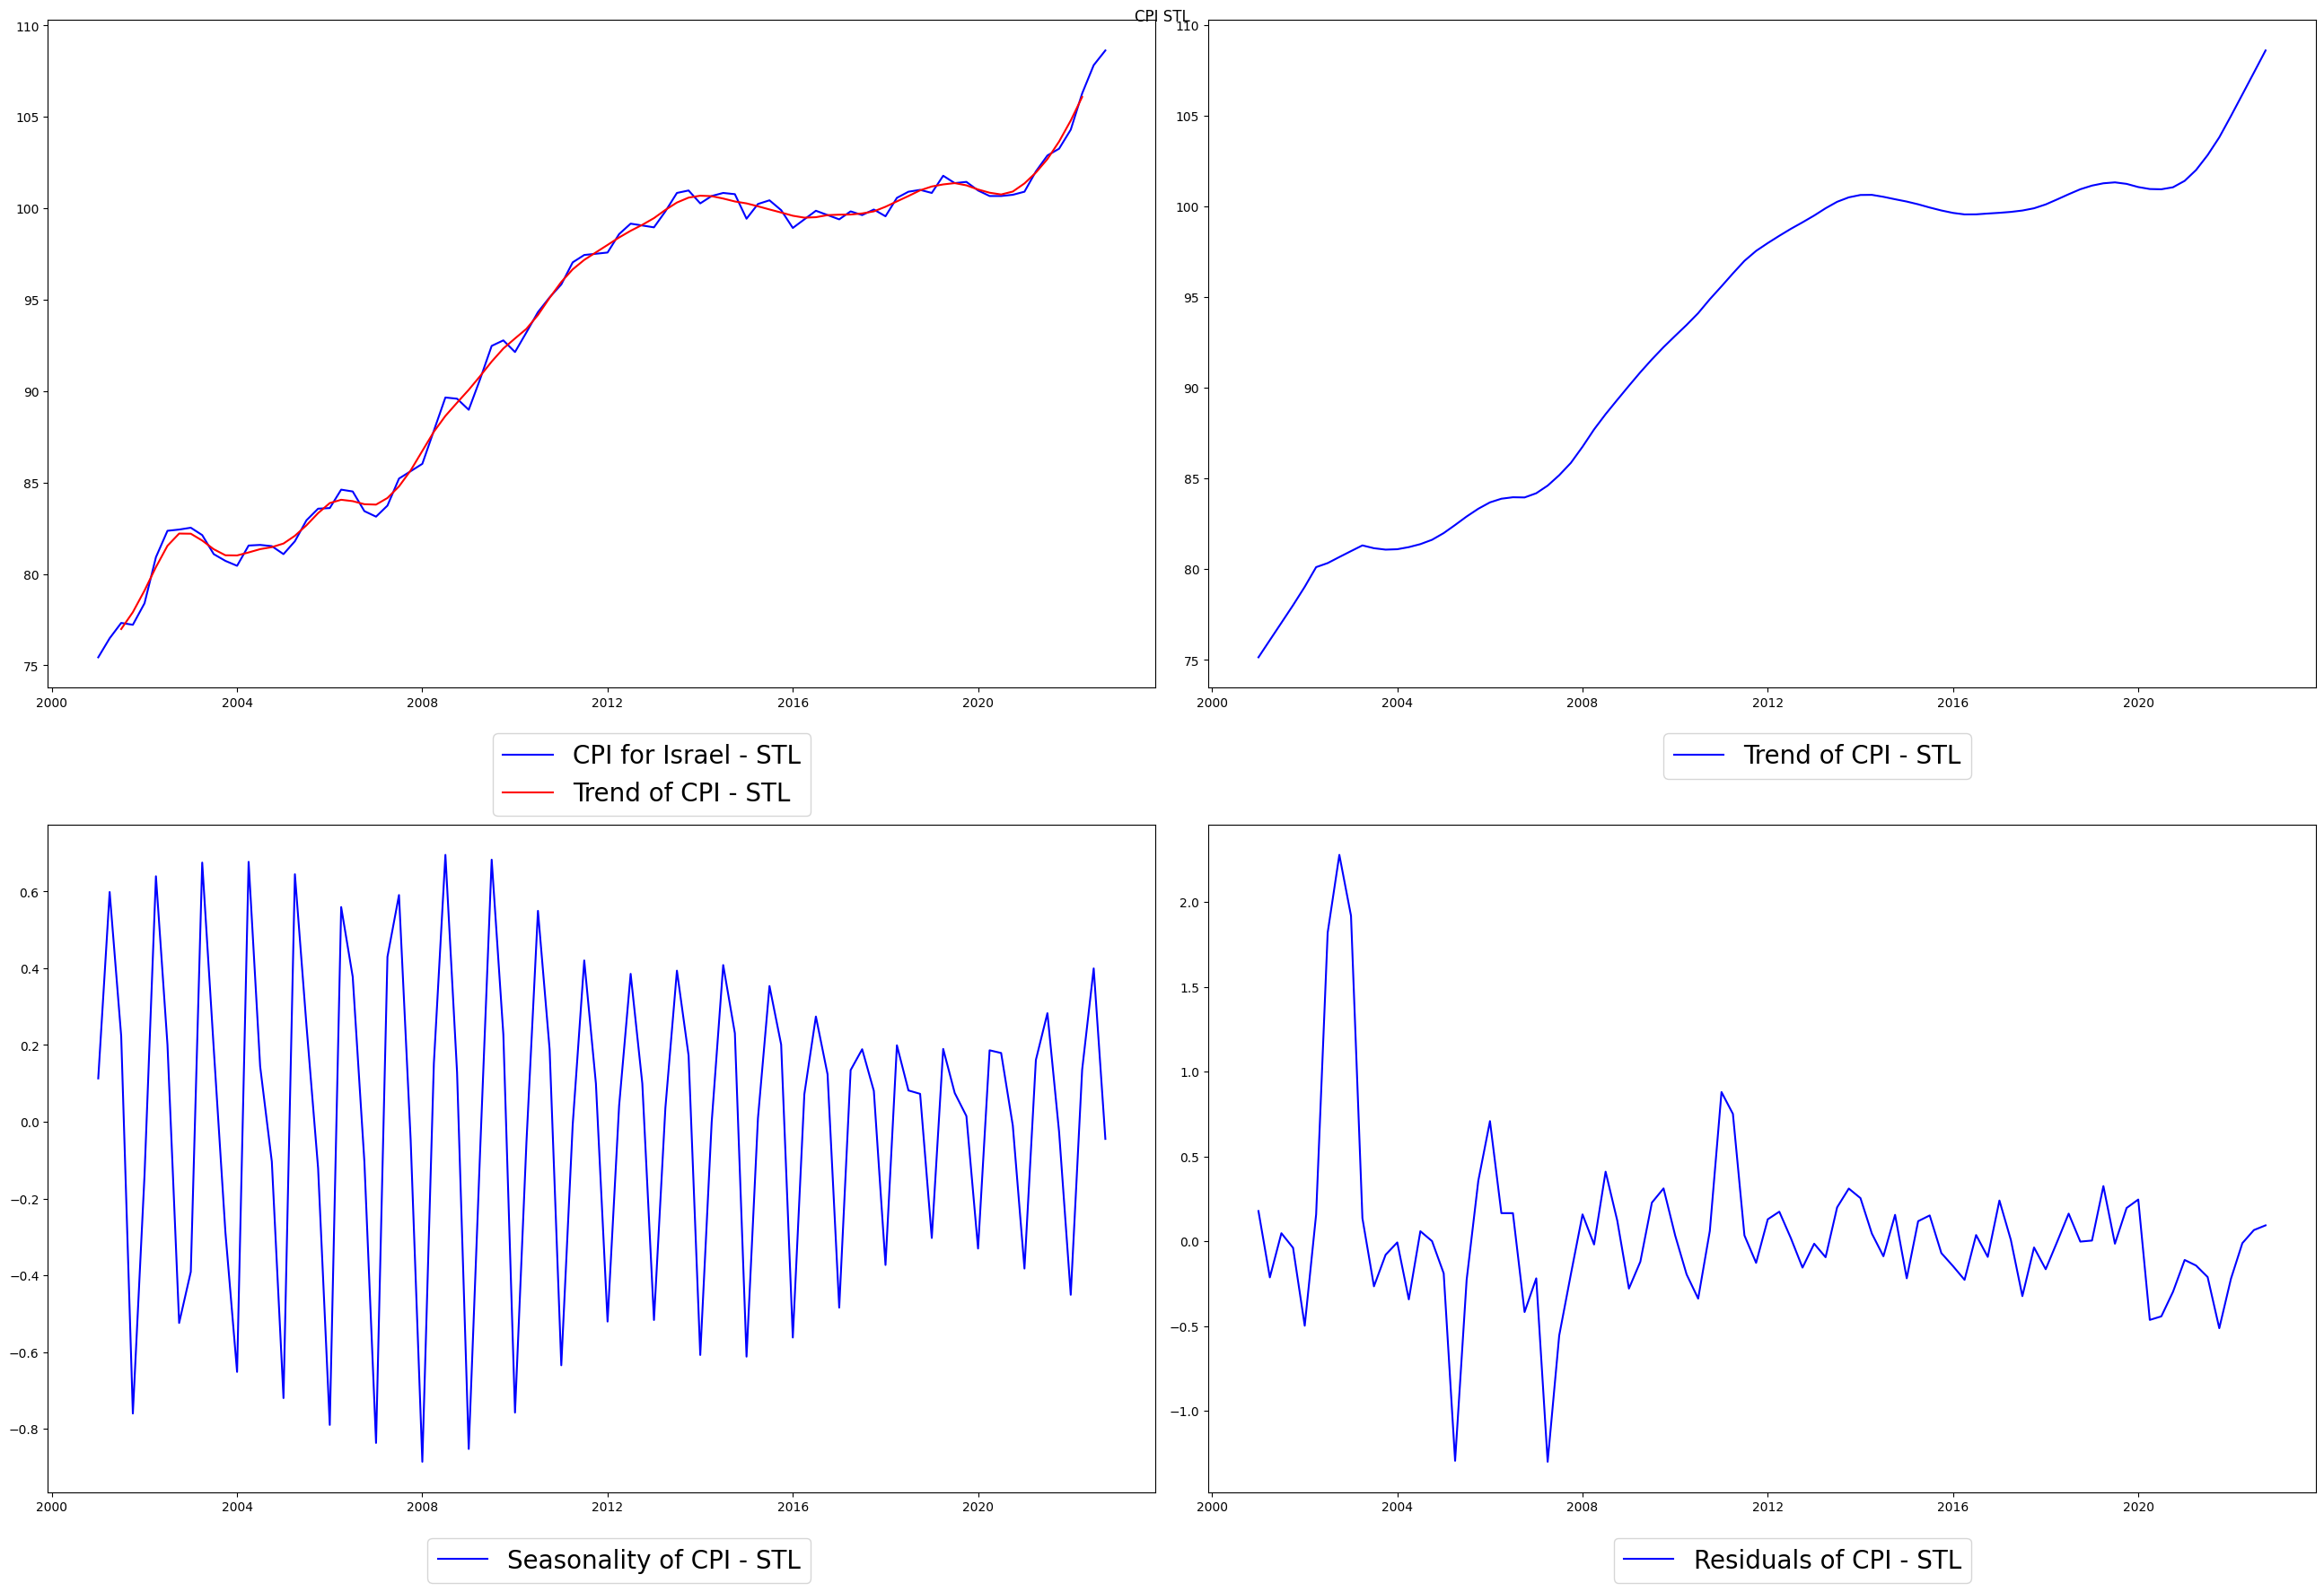

In [14]:
# decompose with STL
cpi_stl = STL(y, robust=True).fit()

plt.rcParams["figure.figsize"] = (26,18)
plt.suptitle('CPI STL', )
plt.subplot(221)
plt.plot(cpi_stl.observed ,label='CPI for Israel - STL', color='blue')
plt.plot(trend_estimate ,label='Trend of CPI - STL' , color='red')
plt.legend(loc='best',fontsize=20 , bbox_to_anchor=(0.70, -0.05))
plt.subplot(222)
plt.plot(cpi_stl.trend ,label='Trend of CPI - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(223)
plt.plot(cpi_stl.seasonal ,label='Seasonality of CPI - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(224)
plt.plot(cpi_stl.resid ,label='Residuals of CPI - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.tight_layout()
plt.show()

In [11]:
# check stationarity for residuals
y_resid = cpi_stl.resid.dropna()
print("\n-------------------------------------------------")
print("Augmented Dickey-Fuller (ADF) test")
print("    H0: unit root (variable is NOT stationary)")
print("    H0: no unit root (variable is stationary)")
print("---------------------------------------------------")

print("ADF test for residuals - various underlying models:")
res = tsa.adfuller(y_resid, regression='c',autolag='AIC')
print("    (1) ADF p-value (const):",res[1])
res = tsa.adfuller(y_resid, regression='ct',autolag='AIC')
print("    (2) ADF p-value (const + trend):",res[1])
res = tsa.adfuller(y_resid, regression='ctt',autolag='AIC')
print("    (3) ADF p-value (const + trend + quad trend):",res[1])
res = tsa.adfuller(y_resid, regression='n',autolag='AIC')
print("    (4) ADF p-value (no const + no trend):",res[1])


-------------------------------------------------
Augmented Dickey-Fuller (ADF) test
    H0: unit root (variable is NOT stationary)
    H0: no unit root (variable is stationary)
---------------------------------------------------
ADF test for residuals - various underlying models:
    (1) ADF p-value (const): 0.00031876519857332867
    (2) ADF p-value (const + trend): 0.00038209689433912165
    (3) ADF p-value (const + trend + quad trend): 0.06112834179042951
    (4) ADF p-value (no const + no trend): 1.8437192586137755e-05



STATIONARITY ANALYSIS FOR: De-seasoned Series with STL

------------------------------- (1) Time series plot -------------------------------


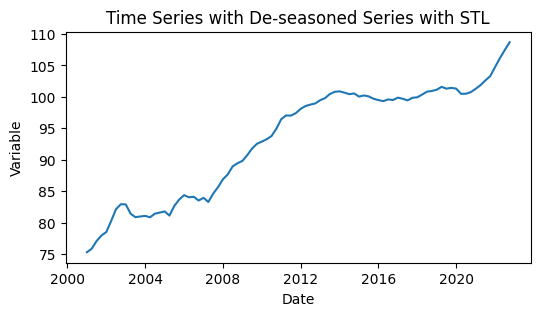

------------------------------- (2) ACF and PACF plot -------------------------------


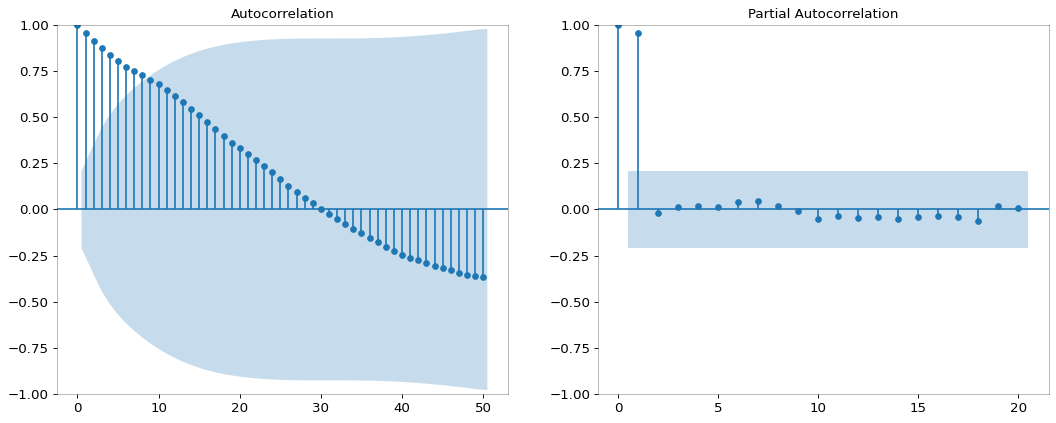

------------------------------- (3) ADF test -------------------------------
ADF test - various underlying models:
    (1) ADF p-value (const): 0.8986765940643631
    (2) ADF p-value (const + trend): 0.5375936044443081
    (3) ADF p-value (const + trend + quad trend): 0.8192736952118423
    (4) ADF p-value (no const + no trend): 0.988996503578044


In [23]:
# plot time series, autocorrelation and partial-autocorrelation functions of deseasoned series
y_deseasoned = y - cpi_stl.seasonal
title = 'De-seasoned Series with STL'
Stationarity_analysis(y_deseasoned, title)



STATIONARITY ANALYSIS FOR: De-trended Series with STL

------------------------------- (1) Time series plot -------------------------------


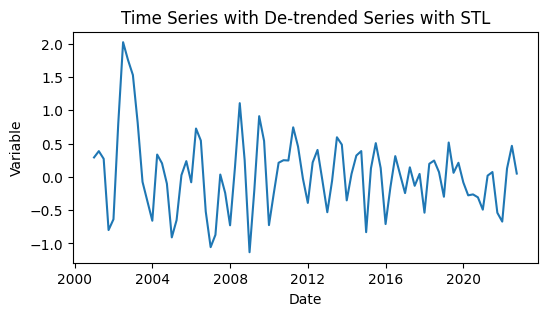

------------------------------- (2) ACF and PACF plot -------------------------------


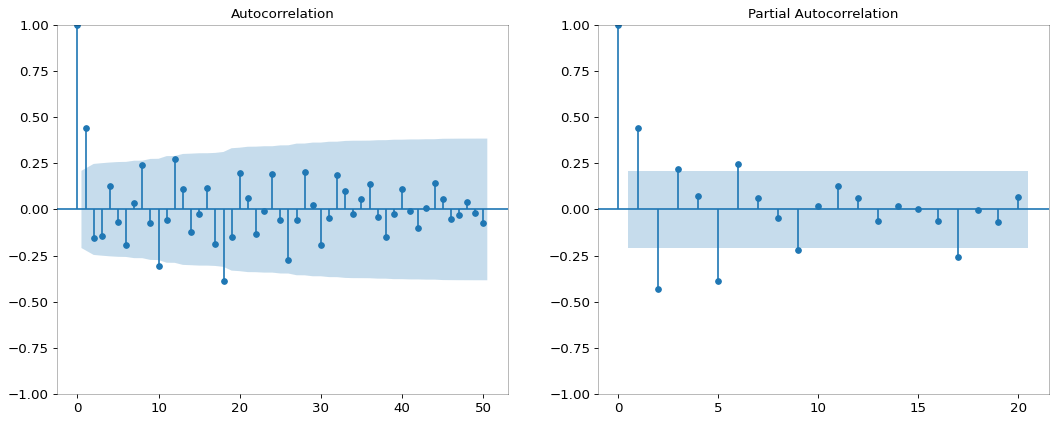

------------------------------- (3) ADF test -------------------------------
ADF test - various underlying models:
    (1) ADF p-value (const): 5.6902338564963445e-06
    (2) ADF p-value (const + trend): 0.00022829750022390632
    (3) ADF p-value (const + trend + quad trend): 0.003716192144185348
    (4) ADF p-value (no const + no trend): 1.4052729233835284e-07


In [26]:
# plot time series, autocorrelation and partial-autocorrelation functions of deseasoned series
y_detrended = y - cpi_stl.trend
title = 'De-trended Series with STL'
Stationarity_analysis(y_detrended, title)


STATIONARITY ANALYSIS FOR: De-seasoned and De-trended Series with STL

------------------------------- (1) Time series plot -------------------------------


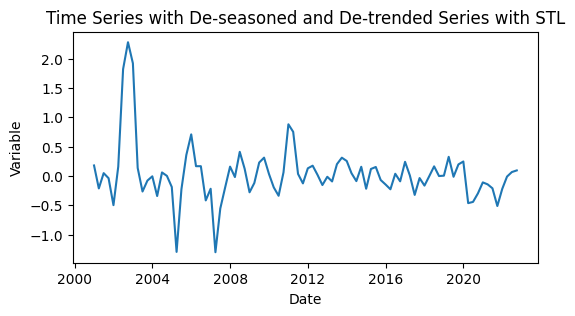

------------------------------- (2) ACF and PACF plot -------------------------------


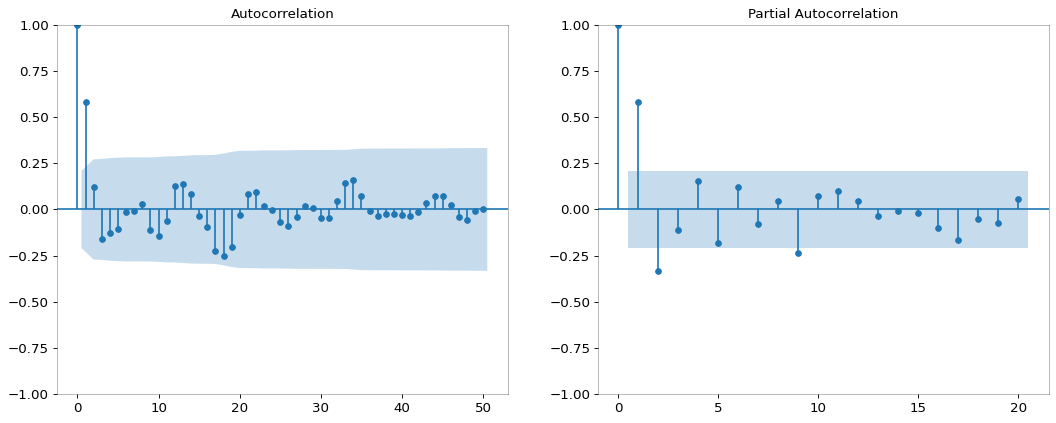

------------------------------- (3) ADF test -------------------------------
ADF test - various underlying models:
    (1) ADF p-value (const): 0.00031876519857332867
    (2) ADF p-value (const + trend): 0.00038209689433912165
    (3) ADF p-value (const + trend + quad trend): 0.06112834179042951
    (4) ADF p-value (no const + no trend): 1.8437192586137755e-05


In [27]:
# plot time series, autocorrelation and partial-autocorrelation functions of deseasoned and detrended series
y_det_des = y - cpi_stl.seasonal - cpi_stl.trend
title = 'De-seasoned and De-trended Series with STL'
Stationarity_analysis(y_det_des, title)


STATIONARITY ANALYSIS FOR: Log and 2nd Order Difference of De-seasoned Series

------------------------------- (1) Time series plot -------------------------------


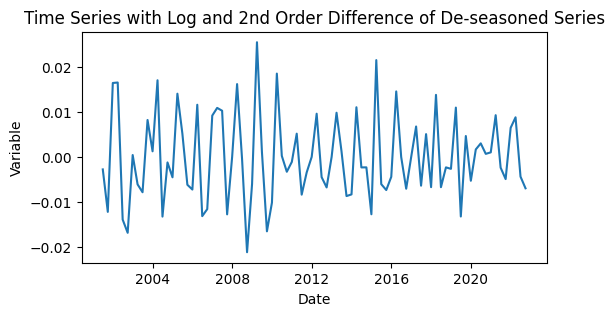

------------------------------- (2) ACF and PACF plot -------------------------------


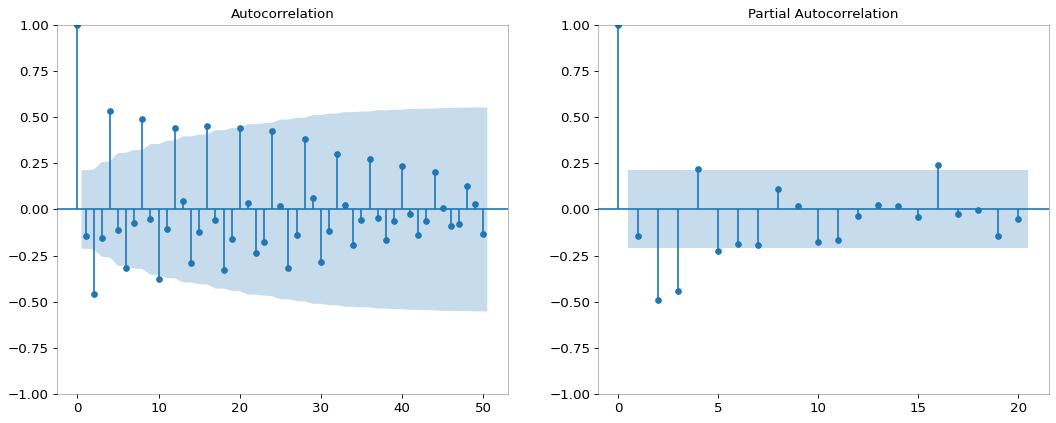

------------------------------- (3) ADF test -------------------------------
ADF test - various underlying models:
    (1) ADF p-value (const): 1.078331227511249e-06
    (2) ADF p-value (const + trend): 6.748456470934213e-06
    (3) ADF p-value (const + trend + quad trend): 1.4732337175883231e-05
    (4) ADF p-value (no const + no trend): 4.657200109662458e-08


In [25]:
# plot time series, autocorrelation and partial-autocorrelation functions of log of 2nd order difference
title = 'Log and 2nd Order Difference of De-seasoned Series'
Stationarity_analysis(ddly, title)



In [38]:
# ARMA(3, 3) model based on ACF and PACF
model = ARIMA(y, order=(3, 2, 1))
model_results = model.fit()

print('Summary of the Estimated Model:')
print(model_results.summary())

Summary of the Estimated Model:
                               SARIMAX Results                                
Dep. Variable:                 amount   No. Observations:                   88
Model:                 ARIMA(3, 2, 1)   Log Likelihood                 -82.109
Date:                Thu, 18 May 2023   AIC                            174.217
Time:                        23:06:10   BIC                            186.489
Sample:                    01-01-2001   HQIC                           179.156
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8575      0.112     -7.632      0.000      -1.078      -0.637
ar.L2         -0.7078      0.104     -6.778      0.000      -0.912      -0.503
ar.L3         -0.661

In [80]:
# Ljung-Box Q test
# BP stat for each autocorrelation order separately

lagnum = 12
BPres = model_results.test_serial_correlation("ljungbox", lags=lagnum)
BPres = BPres[0]

BPstat = pd.DataFrame(
    {
        "lag": list(range(1, lagnum + 1)),
        "ljungbox stat": BPres[0],
        "p-value": BPres[1],
    }
)
BPstat

print("\n (3) Testing serial correlation - Ljung-Box Q test:")
print("     H0: no serial correlation for a given lag")
print(BPstat)
print(
    "----------------------------------------------------------------------------------------------\n"
)



 (3) Testing serial correlation - Ljung-Box Q test:
     H0: no serial correlation for a given lag
    lag  ljungbox stat   p-value
0     1       0.005400  0.941421
1     2       0.009218  0.995402
2     3       0.898625  0.825760
3     4       3.969906  0.410094
4     5       4.781723  0.443096
5     6       4.944046  0.551009
6     7       4.964388  0.664309
7     8       5.536442  0.698999
8     9       5.637750  0.775555
9    10       8.014202  0.627450
10   11       8.049318  0.708879
11   12       8.812549  0.718852
----------------------------------------------------------------------------------------------



# Ljung-Box Q* test and Box-Pierce Test
#### https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
### Lags: 
*"If lags is a list or array, then all lags are included up to the largest lag in the list, however only the tests for the lags in the list are reported."*


In [87]:
# Ljung-Box Q* test
sm.stats.acorr_ljungbox(model_results.resid, lags=[12], return_df=True, model_df=4, boxpierce=True)


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,13.874594,0.085093,13.40503,0.098653


### Description
#### Ljung-Box: 

<img align="right" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/df44d87dccf7b56d16ceae7c44880053de9ff3a7"
     alt="Ljung-Box Formula"
     style="clear: both; margin-right: 10px; background-color: white;" />

* A portmanteau test, where:
    * H0: the data is independently distributed (for all lags up to tested lag jointly).
    * H1: the data exhibits some serial correlation.
* The results  are compared to a  χ2 distribution with h degrees of freedom (where h is the number of lags being tested)
* When used to test the model residuals, the degrees of freedom are deducted the number of estimated parameters in the ARMA model (p and q)
* It can be described as a weighted sum of squared autocorrelations at lags 1 through h
* A significant result (a result with p-value smaller than a given alpha) indicate a significant autocorrelation in the data for the given lags

#### Box-Pierce:

<img align="right" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/cf757b9bfb96d2980b0536f9758aeb49ae06a631"
     alt="Box-Pierce Formula"
     style="clear: both; margin-right: 10px; background-color: white;" />

* Similarly to Ljung-Box, it is a portmanteau test, where:
    * H0: the data is independently distributed (for all lags up to tested lag jointly).
    * H1: the data exhibits some serial correlation.
* It is similar to the Ljung-Box test in certain features:
    * Q statistic with m degrees of freedom (minus the number of estimated parameters for ARMA model)
    * The results are compared to a  χ2. When testing the residuals of an ARMA model, the distribution has h-p-q degrees of freedom.
* It differs from the Ljung-Box test (which was developed to answer the deficiency in Box-Pierce), by the fact that it is shown to considerably deviate from a χ2 distribution for all sample sizes, including moderate and small smaples.
    * The imperfection of the Box-Pierce test raises the risk of commiting a type 1 error (Ray and Xiaolou)
    * To resolve this, a weighted term is added to the Ljung-Box test (and subsequent models which attempted to prevent the test's over-correction, e.g. Fisher, 2011 or Monti, 1994)



In [ ]:
# compare several proposed ARMA models using Ljung-Box and Box-Pierce
